<a href="https://colab.research.google.com/github/nainpatel28/demo/blob/main/marvelordc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -Uqq duckduckgo_search

     |████████████████████████████████| 96 kB 3.1 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')


In [4]:
urls = search_images('Marvel character', max_images=2)
urls[0:1]

(#1) ['http://wallpapercave.com/wp/u347Fu3.jpg']

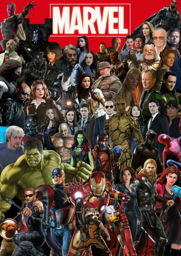

In [5]:
from fastdownload import download_url
dest = 'marvel.jpg'
download_url(urls[1], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)


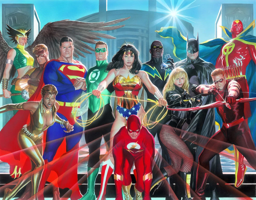

In [6]:
download_url(search_images('Dc character', max_images=2)[1], 'dccharacter.jpg', show_progress=False)
Image.open('dccharacter.jpg').to_thumb(256,256)

In [ ]:
# download_url(search_images('us visiting card', max_images=2)[1], 'forest.jpg', show_progress=False)
# Image.open('forest.jpg').to_thumb(256,256)

In [7]:
searches = 'Marvel Character','Dc Character'
path = Path('MarvelorDc')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} Single character'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} Multi character'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:1015: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")


In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)


0

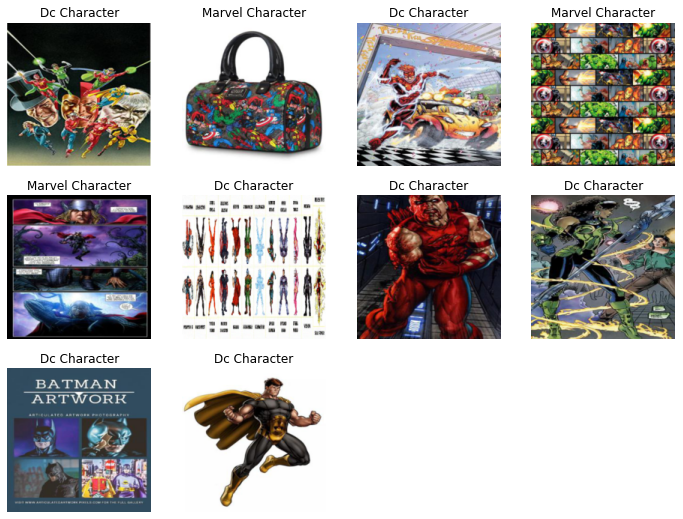

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=10)


In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.384061,1.058630,0.477941,01:19


epoch,train_loss,valid_loss,error_rate,time
0,0.880396,1.020217,0.455882,01:49
1,0.745913,1.147613,0.404412,01:48
2,0.585871,1.153226,0.433824,01:47


In [15]:
learn.export('model.pkl')

In [11]:
pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.6 MB 20.2 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 106 kB 61.3 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 
     |████████████████████████████████| 2.3 MB 50.9 MB/s 
     |████████████████████████████████| 272 kB 52.9 MB/s 
     |████████████████████████████████| 213 kB 70.0 MB/s 
     |████████████████████████████████| 64 kB 2.8 MB/s 
     |████████████████████████████████| 80 kB 9.0 MB/s 
     |████████████████████████████████| 68 kB 6.6 MB/s 
     |████████████████████████████████| 68 kB 5.5 MB/s 
     |████████████████████████████████| 68 kB 6.9 MB/s 
     |████████████████████████████████| 46 kB 4.1 

In [12]:
!pip install -Uqq fastai

In [16]:
from fastai.vision.all import *
import gradio as gr
def is_marvel(x): return x[0].isupper()

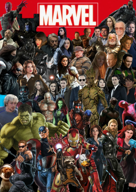

In [17]:
im = PILImage.create('/content/marvel.jpg')
im.thumbnail((192,192))
im

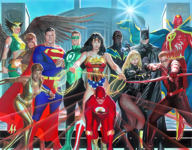

In [18]:
im = PILImage.create('/content/dccharacter.jpg')
im.thumbnail((192,192))
im

In [19]:
learn =load_learner('/content/model.pkl')

In [20]:
learn.predict(im)

('Marvel Character', TensorBase(1), TensorBase([0.1493, 0.8507]))

In [22]:
categories = ('Marvel','Dc')
 
def classify_image(img):
  pred,idx,probs = learn.predict(img)
  return dict(zip(categories,map(float,probs)))

In [23]:
classify_image(im)

{'Marvel': 0.14926518499851227, 'Dc': 0.8507348299026489}

In [25]:
#gradio interface
image = gr.inputs.Image(shape=(192,192))
label=gr.outputs.Label()
examples=['/content/marvel.jpg','/content/dccharacter.jpg']
intf=gr.Interface(fn=classify_image,inputs=image,outputs=label,example=examples)
intf.launch(inline=False)

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
 

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.
